![mercado libre logo](https://res-2.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_170,w_170,f_auto,b_white,q_auto:eco/v1456160088/dauw8qmiutpmqx4wvwlf.png)

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from scipy.special import exp10
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor


In [4]:
%matplotlib inline
sns.set_context('notebook')
sns.set_style('whitegrid')

# Machine Learning model development - GLM trial (Poisson Regressor)

In [28]:
df = pd.read_pickle('categoriesDF.pkl')

In [4]:
df.shape

(13623, 128)

In [29]:
features = [

 'price',
 'available_quantity',
 'sold_quantity',
 'condition',
 'accepts_mercadopago',
 'original_price',
  'seller.seller_reputation.transactions.completed',
 'seller.seller_reputation.transactions.ratings.positive',
 'seller.seller_reputation.transactions.ratings.negative',
 'seller.seller_reputation.metrics.sales.completed',
  'seller.seller_reputation.metrics.sales.period',
  'seller.seller_reputation.metrics.cancellations.rate',
   'seller.seller_reputation.metrics.claims.rate',
    'installments.quantity',
  'shipping.free_shipping',
  'shipping.mode',
]

In [30]:
df = df[features] 

In [31]:
seller_features = ['seller.seller_reputation.transactions.completed',
 'seller.seller_reputation.transactions.ratings.positive',
 'seller.seller_reputation.transactions.ratings.negative',
 'seller.seller_reputation.metrics.sales.completed',
  'seller.seller_reputation.metrics.sales.period',
  'seller.seller_reputation.metrics.cancellations.rate',
   'seller.seller_reputation.metrics.claims.rate',]

In [32]:
seller_features_clean = []
for i in seller_features:
    
    seller_features_clean.append(i.split('seller.seller_reputation.')[-1])

In [33]:
df.rename(columns= dict(zip(seller_features,seller_features_clean)), inplace=True)

In [34]:
df['installments.quantity'].fillna(value=0, inplace=True)


In [35]:
df['installments.quantity'].unique()

array([12., 18.,  9.,  3.,  6.,  0.])

### features construction


In [36]:
df['discount_value'] = df['original_price'] - df['price']
df['discount_pct'] = df['discount_value']/df['original_price']
df['has_discount'] = df.discount_value.apply(lambda val: 'no' if str(val) == 'nan' else 'yes')

In [37]:
df['discount_value'].fillna(value=0, inplace=True)
df['discount_pct'].fillna(value=0, inplace=True)


In [ ]:
df['sold_per_available'] = df['sold_quantity']/df['available_quantity']

## Distribution Plots

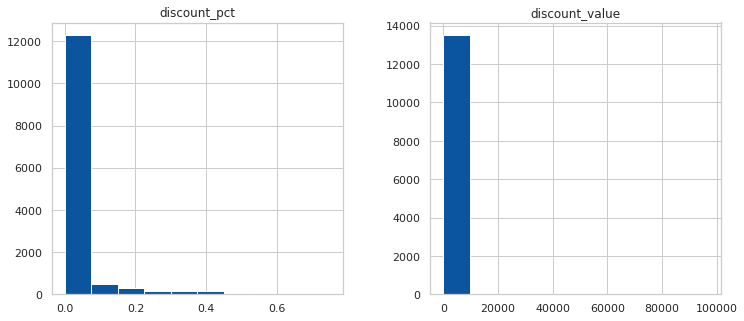

In [10]:
df[['discount_pct','discount_value']].hist(figsize=(12,5))
plt.show()

really assymetric feature, probably a good idea to use log scale

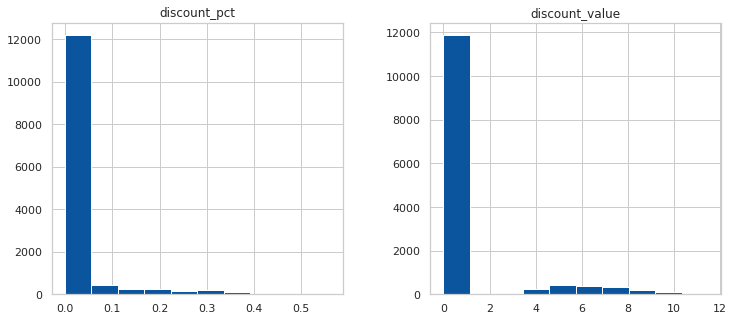

In [32]:
df[['discount_pct','discount_value']].apply(np.log1p).hist(figsize=(12,5))
plt.show()

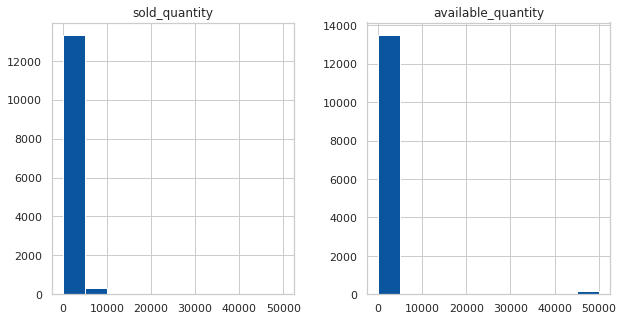

In [33]:
df[['sold_quantity', 'available_quantity']].hist(figsize=(10,5))
plt.show()

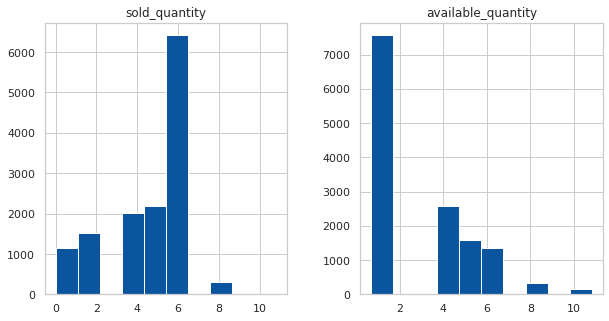

In [35]:
df[['sold_quantity', 'available_quantity']].apply(np.log1p).hist(figsize=(10,5))
plt.show()

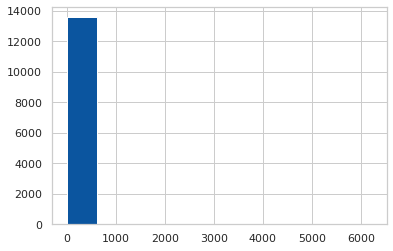

In [41]:
df['sold_per_available'].hist()
plt.show()

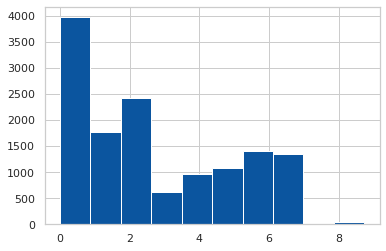

In [42]:
df['sold_per_available'].apply(np.log1p).hist()
plt.show()

ratio of sold_quantity per available quantity looks like a poisson distribution, often used to predict count targets. instead of predicting 'sold_quantity' I'll try to develop a model to predict sold_quantity/available_quantity

## features distribution without log scaling

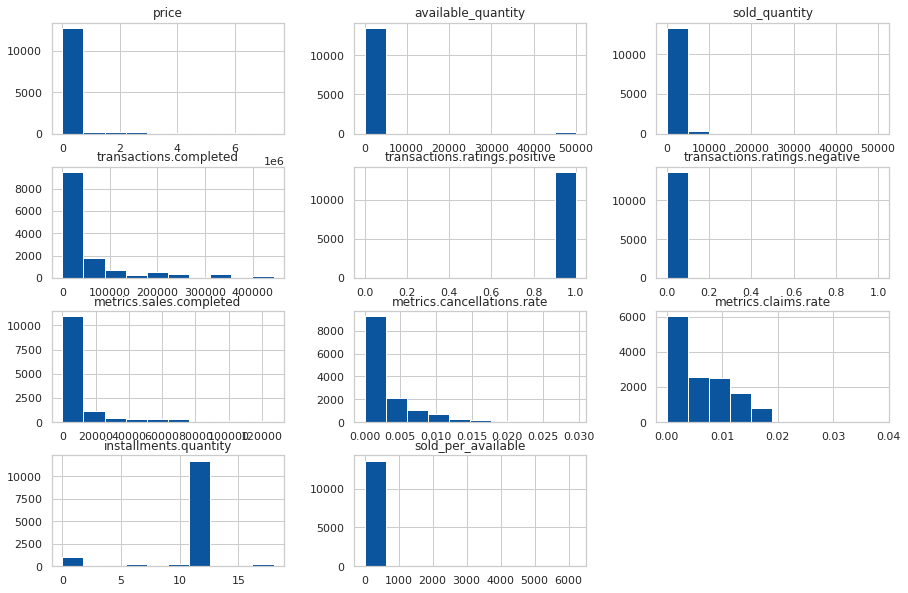

In [53]:
df.drop(columns=(['original_price', 'discount_value', 'discount_pct'])).select_dtypes(include='number').hist(figsize=(15,10))
plt.show()


## features distribution with log scaling

we can see that applying log transfomation brings some of the features closer to normality

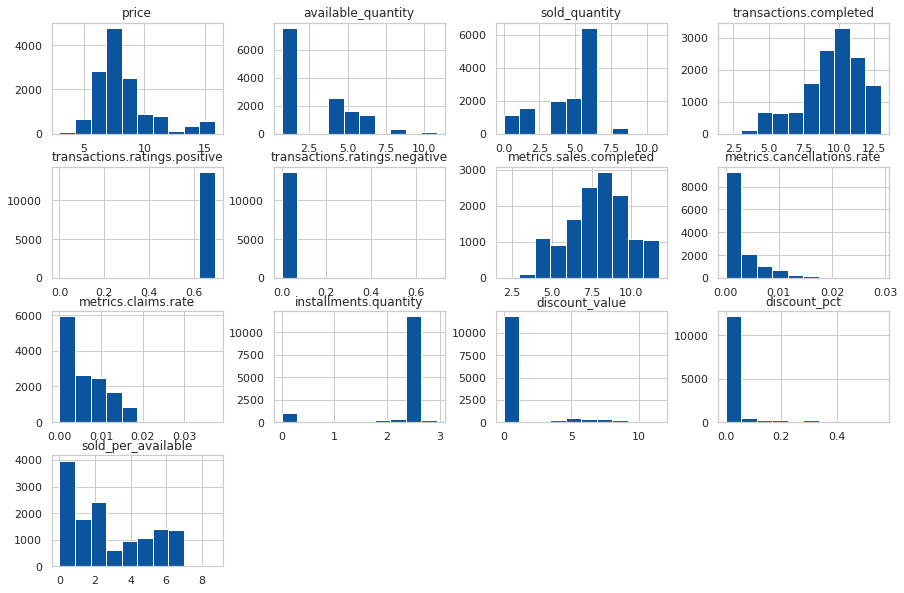

In [57]:
df.drop(columns=(['original_price'])).select_dtypes(include='number').apply(np.log1p).hist(figsize=(15,10))
plt.show()

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## feature preprocessor pipeline

In [120]:
log_scale_transformer = make_pipeline(
    
    FunctionTransformer(np.log1p, validate=False),
    StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough",
            ["installments.quantity","transactions.ratings.positive", "metrics.claims.rate",
             "metrics.cancellations.rate"]
        ),

        ("log_scaled_numeric", log_scale_transformer,
            ["price", "transactions.completed", "metrics.sales.completed", 'discount_value', 'discount_pct']
        ),
        ("onehot_categorical", OneHotEncoder(),
            list(df.drop(columns=['accepts_mercadopago']).select_dtypes(exclude="number"))
        ),
    ],
    remainder="drop",
)


## Evaluation function

When using GLMs R2 does mpt represent the proportion of variance explained. instead we use poisson deviance

In [41]:
def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print("MSE: %.3f" %
          mean_squared_error(df_test["sold_per_available"], y_pred,
                             sample_weight=df_test["available_quantity"]))
    
    
    print("RMSE: %.3f" %
          np.sqrt(mean_squared_error(df_test["sold_per_available"], y_pred,
                             sample_weight=df_test["available_quantity"])) )
    print("MAE: %.3f" %
          mean_absolute_error(df_test["sold_per_available"], y_pred,
                              sample_weight=df_test["available_quantity"]))

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.

    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(f"WARNING: Estimator yields invalid, non-positive predictions "
              f" for {n_masked} samples out of {n_samples}. These predictions "
              f"are ignored when computing the Poisson deviance.")

    print("mean Poisson deviance: %.3f" %
          mean_poisson_deviance(df_test["sold_per_available"][mask],
                                y_pred[mask],
                                sample_weight=df_test["available_quantity"][mask]))



In [46]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

In [121]:
from sklearn.metrics import mean_poisson_deviance

ridge_glm = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", Ridge(alpha=0.1, fit_intercept=True)),
]).fit(df_train, df_train["sold_per_available"],
       regressor__sample_weight=df_train["available_quantity"])

In [122]:
score_estimator(ridge_glm, df_test)

MSE: 190.089
RMSE: 13.787
MAE: 0.759
mean Poisson deviance: 3.484


In [123]:
from sklearn.linear_model import PoissonRegressor, TweedieRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", TweedieRegressor(power=1, warm_start=True, link='log'))
])
poisson_glm.fit(df_train, df_train["sold_per_available"],
                regressor__sample_weight=df_train["available_quantity"])

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 190.151
RMSE: 13.790
MAE: 0.781
mean Poisson deviance: 3.583


In [55]:
y_pred = poisson_glm.predict(df_test)

In [99]:
print('predicted number of sales',np.sum(y_pred * df_test['available_quantity']))

predicted number of sales 1425659.001270777


In [100]:
print('actual number of sales:',np.sum(df_test['sold_quantity']) )

actual number of sales: 1709593


In [105]:
print('percentual error of sold quantity:')
100 *(np.sum(df_test['sold_quantity']) - np.sum(y_pred * df_test['available_quantity']))/np.sum(df_test['available_quantity'])

percentual error of sold quantity:


8.696067597910098

## Save Model

In [110]:
ridge_glm['regressor']

Ridge(alpha=0.1)

In [50]:
import pickle

In [51]:
filename = 'poisson_model_ml.pkl'
pickle.dump(poisson_glm, open(filename, 'wb'))

In [112]:
df_test.columns

Index(['price', 'available_quantity', 'sold_quantity', 'condition',
       'accepts_mercadopago', 'original_price', 'transactions.completed',
       'transactions.ratings.positive', 'transactions.ratings.negative',
       'metrics.sales.completed', 'metrics.sales.period',
       'metrics.cancellations.rate', 'metrics.claims.rate',
       'installments.quantity', 'shipping.free_shipping', 'shipping.mode',
       'discount_value', 'discount_pct', 'has_discount', 'sold_per_available'],
      dtype='object')

# items compatible features

In [118]:
features_items = ['accepts_mercadopago',
 'available_quantity',
 'condition',
 'original_price',
 'price',
 'shipping.free_shipping',
 'shipping.mode',
 'sold_quantity',
 'discount_value', 
 'discount_pct', 
 'sold_per_available',
 'has_discount'
           ]

In [119]:
df[features_items]

,accepts_mercadopago,available_quantity,condition,original_price,price,shipping.free_shipping,shipping.mode,sold_quantity,discount_value,discount_pct,sold_per_available,has_discount
0,True,8,new,NaN,360.00,False,not_specified,0,0.00,0.000000,0.000000,no
1,True,37,new,NaN,2090.00,False,me2,217,0.00,0.000000,5.864865,no
2,True,68,new,430.12,387.11,False,me2,438,43.01,0.099995,6.441176,yes
3,True,30,new,NaN,42.00,False,me2,0,0.00,0.000000,0.000000,no
4,True,230,new,NaN,3970.00,True,me2,122,0.00,0.000000,0.530435,no
...,...,...,...,...,...,...,...,...,...,...,...,...
13618,True,1,new,NaN,4600.00,True,me2,150,0.00,0.000000,150.000000,no
13619,True,1,new,1484.20,1365.46,False,me2,25,118.74,0.080003,25.000000,yes
13620,True,1,new,NaN,1965.00,False,me2,200,0.00,0.000000,200.000000,no
13621,True,1,new,NaN,335.00,False,me2,150,0.00,0.000000,150.000000,no


In [128]:
log_scale_transformer_items = make_pipeline(
    
    FunctionTransformer(np.log1p, validate=False),
    StandardScaler()
)

linear_model_preprocessor_items = ColumnTransformer(
    [
      #  ("passthrough_numeric", "passthrough",
      #      ["installments.quantity","transactions.ratings.positive", "metrics.claims.rate",
       #      "metrics.cancellations.rate"]
       # ),

        ("log_scaled_numeric", log_scale_transformer,
            ["price",  'discount_value', 'discount_pct']
        ),
        ("onehot_categorical", OneHotEncoder(),
            list(df[features_items].drop(columns=['accepts_mercadopago']).select_dtypes(exclude="number"))
        ),
    ],
    remainder="drop",
)

In [132]:
n_samples = df_train[features_items].shape[0]

poisson_glm_items = Pipeline([
    ("preprocessor", linear_model_preprocessor_items),
    ("regressor", TweedieRegressor(power=1, warm_start=True, link='log'))
])
poisson_glm.fit(df_train[features_items], df_train["sold_per_available"],
                regressor__sample_weight=df_train["available_quantity"])

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test[features_items])

PoissonRegressor evaluation:
MSE: 190.151
RMSE: 13.790
MAE: 0.781
mean Poisson deviance: 3.583


In [133]:
filename = 'poisson_model_ml.pkl'
pickle.dump(poisson_glm, open(filename, 'wb'))